# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.precision', 10)
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example
import torch

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 71]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 71]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

model_path = "/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/no2_o3_co_testing_model/"

# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 8)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id'],
      dtype='object')


date    NO2_quantrac  PM25_quantrac    O3_quantrac  \
0     2021-02-23 21:00:00  112.7407619000  15.6047619000  55.4313809500   
1     2021-02-23 22:00:00  112.3664706000  14.5941176500  58.1971764700   
2     2021-02-23 23:00:00  112.7004333000  13.4366666700  55.0294333300   
3     2021-02-24 00:00:00  112.4808667000  12.3650000000  54.7677000000   
4     2021-02-24 01:00:00  114.3315000000  11.6366666700  53.7862000000   
...                   ...             ...            ...            ...   
92961 2022-12-31 19:00:00    0.0882333333  41.4500000000  75.9166666667   
92962 2022-12-31 20:00:00    0.0832166667  50.5300000000  66.1166666667   
92963 2022-12-31 21:00:00    0.0843000000  55.0550000000  55.1333333333   
92964 2022-12-31 22:00:00    0.0666500000  26.0783333333  46.7500000000   
92965 2022-12-31 23:00:00    0.0677833333  21.1616666667  50.0166666667   

           CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.0000000000         28.3619047600   63.1880952400         211  
1      1200.6035290000         28.3205882400   63.7735294100         211  
2      1177.8970000000         28.3366666700   64.2050000000         211  
3        90.0000000000         28.3050000000   64.7350000000         211  
4        90.0000000000         28.3000000000   65.1883333300         211  
...                ...                   ...             ...         ...  
92961     2.0871666667         27.6900000000   67.2900000000         216  
92962     2.0065000000         27.4016666667   68.0266666667         216  
92963     2.4188333333         27.6033333333   66.9650000000         216  
92964     1.4815000000         27.0366666667   63.3616666667         216  
92965     1.3011666667         26.3583333333   63.3433333333         216  

[92966 rows x 8 columns]

In [3]:
df_all.isnull().sum()

date                        0
NO2_quantrac            43684
PM25_quantrac           43043
O3_quantrac             47797
CO_quantrac             43760
Temperature_quantrac    52890
Humid_quantrac          52890
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped_na = df_all.dropna().reset_index(drop=True)

df_dropped = df_dropped_na.reset_index(drop=True)
df_dropped

date    NO2_quantrac  PM25_quantrac    O3_quantrac  \
0     2021-02-23 21:00:00  112.7407619000  15.6047619000  55.4313809500   
1     2021-02-23 22:00:00  112.3664706000  14.5941176500  58.1971764700   
2     2021-02-23 23:00:00  112.7004333000  13.4366666700  55.0294333300   
3     2021-02-24 00:00:00  112.4808667000  12.3650000000  54.7677000000   
4     2021-02-24 01:00:00  114.3315000000  11.6366666700  53.7862000000   
...                   ...             ...            ...            ...   
38704 2022-12-31 19:00:00    0.0882333333  41.4500000000  75.9166666667   
38705 2022-12-31 20:00:00    0.0832166667  50.5300000000  66.1166666667   
38706 2022-12-31 21:00:00    0.0843000000  55.0550000000  55.1333333333   
38707 2022-12-31 22:00:00    0.0666500000  26.0783333333  46.7500000000   
38708 2022-12-31 23:00:00    0.0677833333  21.1616666667  50.0166666667   

           CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.0000000000         28.3619047600   63.1880952400         211  
1      1200.6035290000         28.3205882400   63.7735294100         211  
2      1177.8970000000         28.3366666700   64.2050000000         211  
3        90.0000000000         28.3050000000   64.7350000000         211  
4        90.0000000000         28.3000000000   65.1883333300         211  
...                ...                   ...             ...         ...  
38704     2.0871666667         27.6900000000   67.2900000000         216  
38705     2.0065000000         27.4016666667   68.0266666667         216  
38706     2.4188333333         27.6033333333   66.9650000000         216  
38707     1.4815000000         27.0366666667   63.3616666667         216  
38708     1.3011666667         26.3583333333   63.3433333333         216  

[38709 rows x 8 columns]

## Visualization

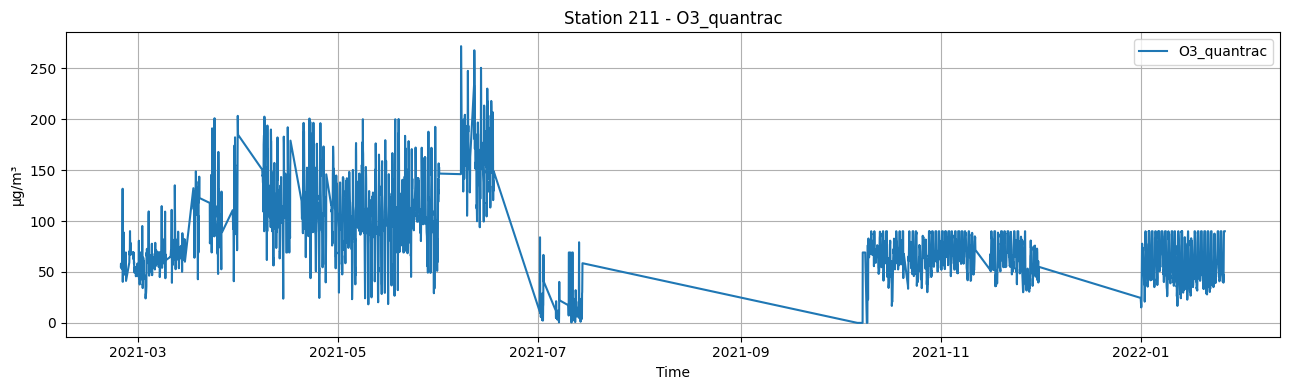

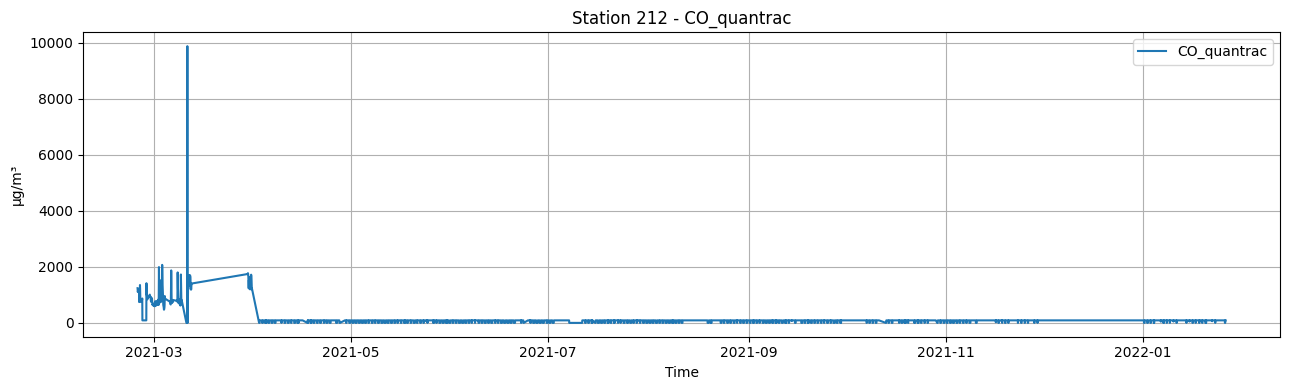

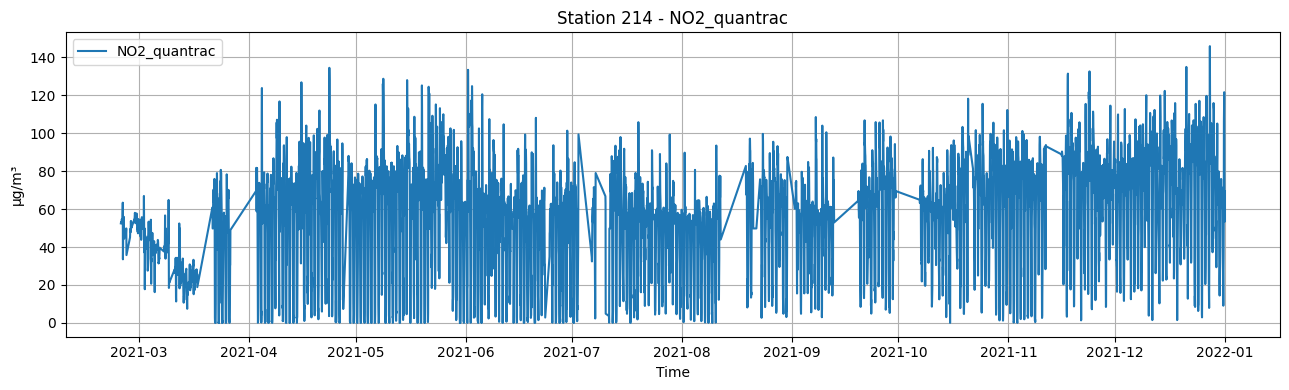

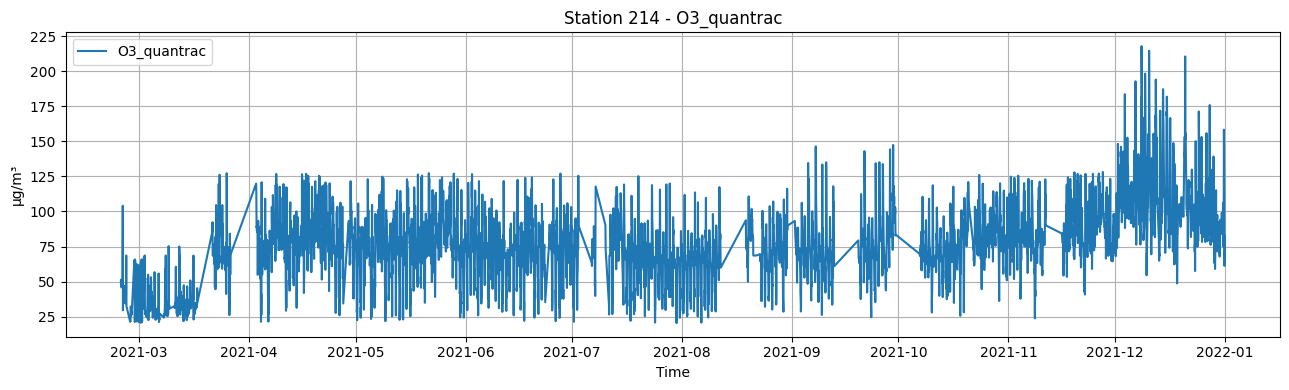

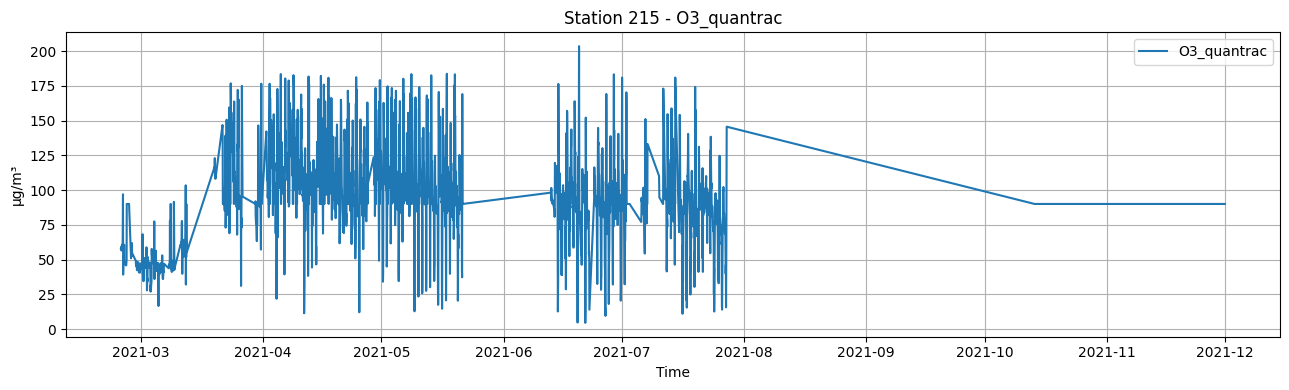

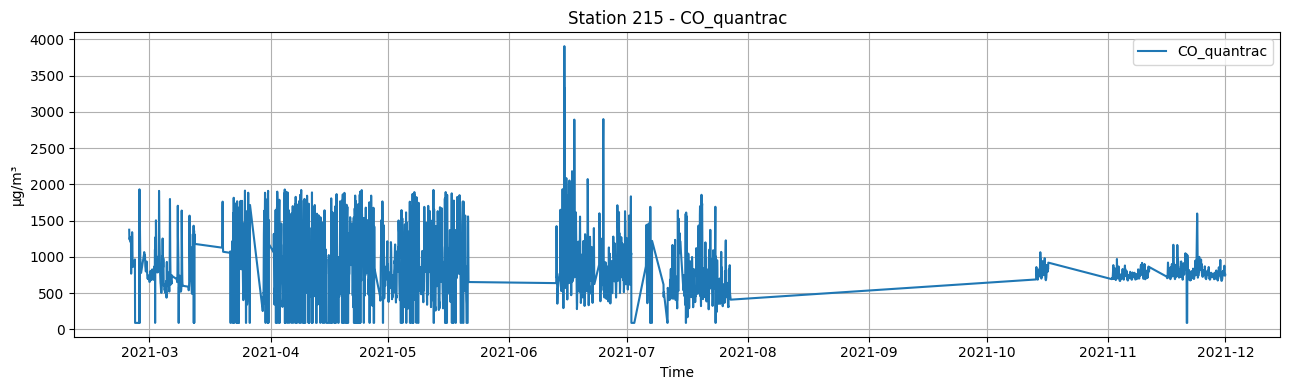

In [5]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [6]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

date    NO2_quantrac  PM25_quantrac    O3_quantrac  \
0     2021-02-23 21:00:00  112.7407619000  15.6047619000  55.4313809500   
1     2021-02-23 22:00:00  112.3664706000  14.5941176500  58.1971764700   
2     2021-02-23 23:00:00  112.7004333000  13.4366666700  55.0294333300   
3     2021-02-24 00:00:00  112.4808667000  12.3650000000  54.7677000000   
4     2021-02-24 01:00:00  114.3315000000  11.6366666700  53.7862000000   
...                   ...             ...            ...            ...   
38704 2022-12-31 19:00:00  166.1610133333  41.4500000000  75.9166666667   
38705 2022-12-31 20:00:00  156.7136266667  50.5300000000  66.1166666667   
38706 2022-12-31 21:00:00  158.7537600000  55.0550000000  55.1333333333   
38707 2022-12-31 22:00:00  125.5152800000  26.0783333333  46.7500000000   
38708 2022-12-31 23:00:00  127.6495733333  21.1616666667  50.0166666667   

           CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.0000000000         28.3619047600   63.1880952400         211  
1      1200.6035290000         28.3205882400   63.7735294100         211  
2      1177.8970000000         28.3366666700   64.2050000000         211  
3        90.0000000000         28.3050000000   64.7350000000         211  
4        90.0000000000         28.3000000000   65.1883333300         211  
...                ...                   ...             ...         ...  
38704  2393.5627333333         27.6900000000   67.2900000000         216  
38705  2301.0542000000         27.4016666667   68.0266666667         216  
38706  2773.9180666667         27.6033333333   66.9650000000         216  
38707  1698.9842000000         27.0366666667   63.3616666667         216  
38708  1492.1779333333         26.3583333333   63.3433333333         216  

[38709 rows x 8 columns]

## Visualization after converting unit

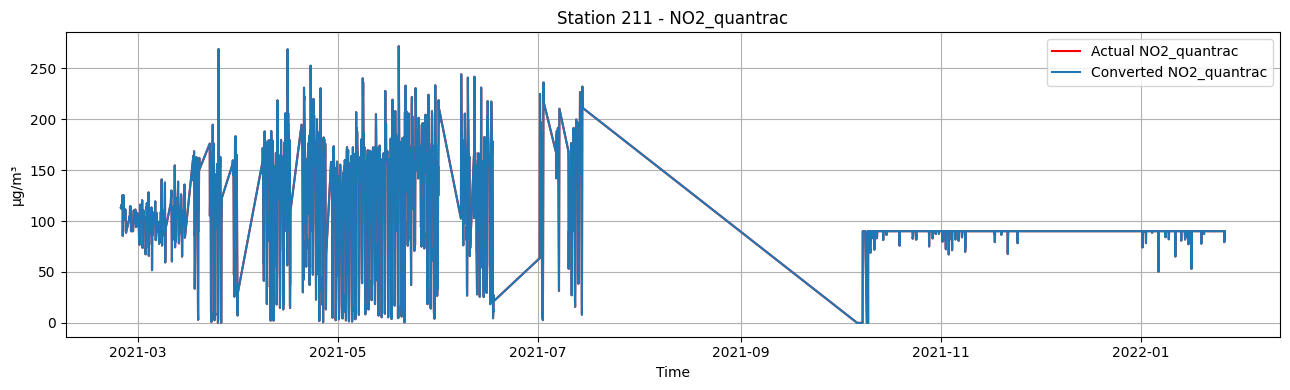

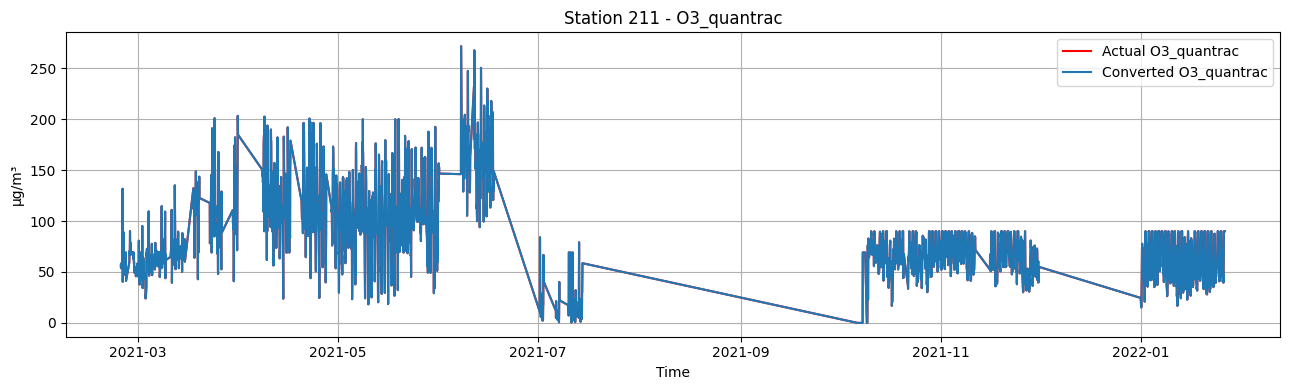

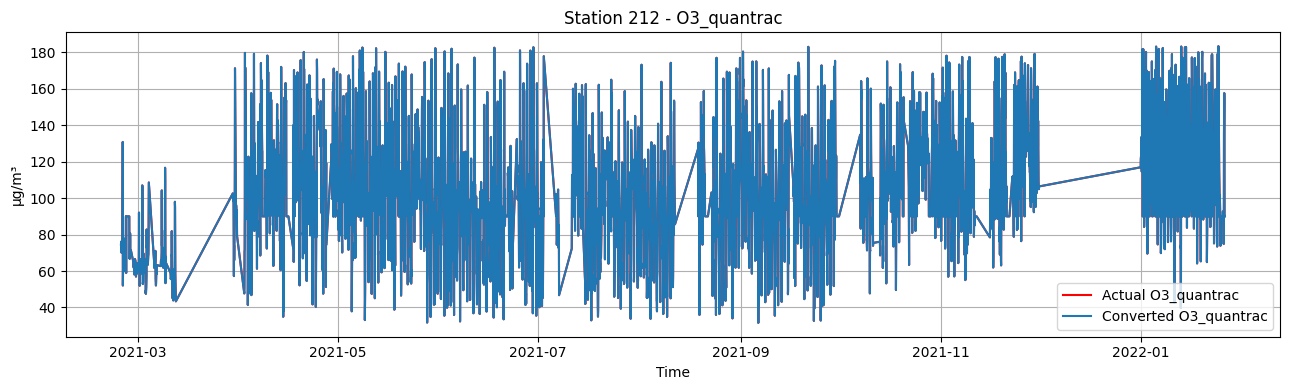

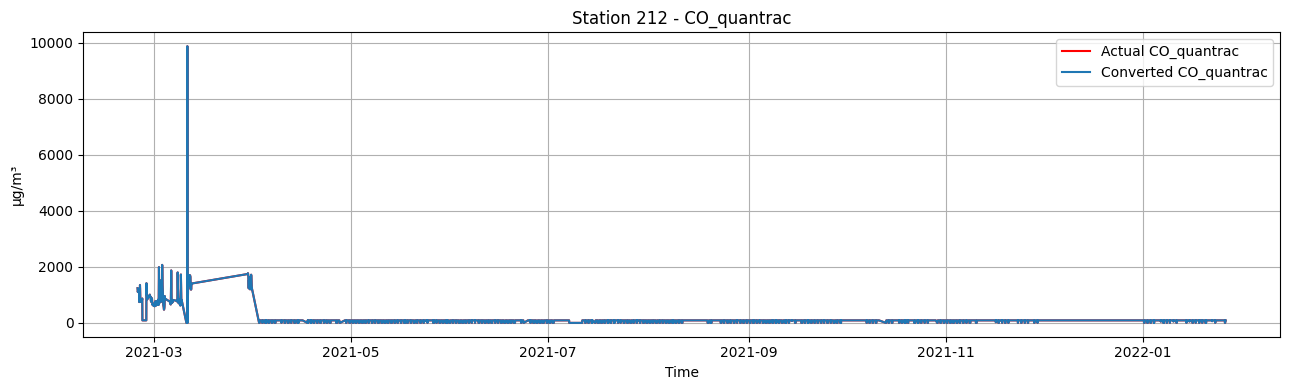

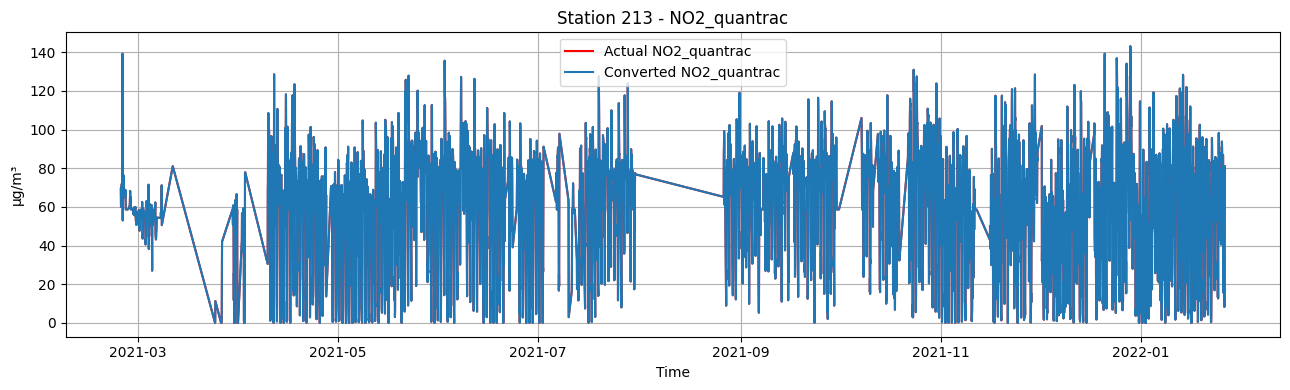

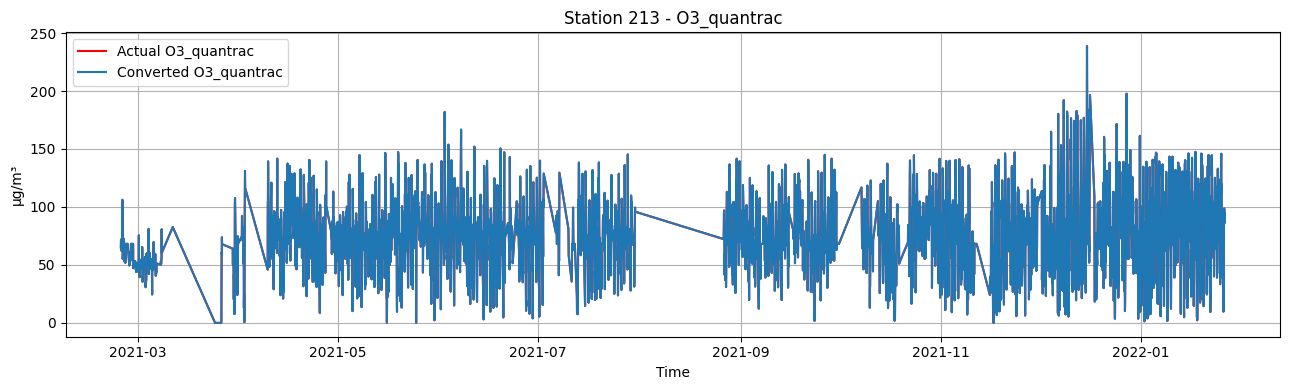

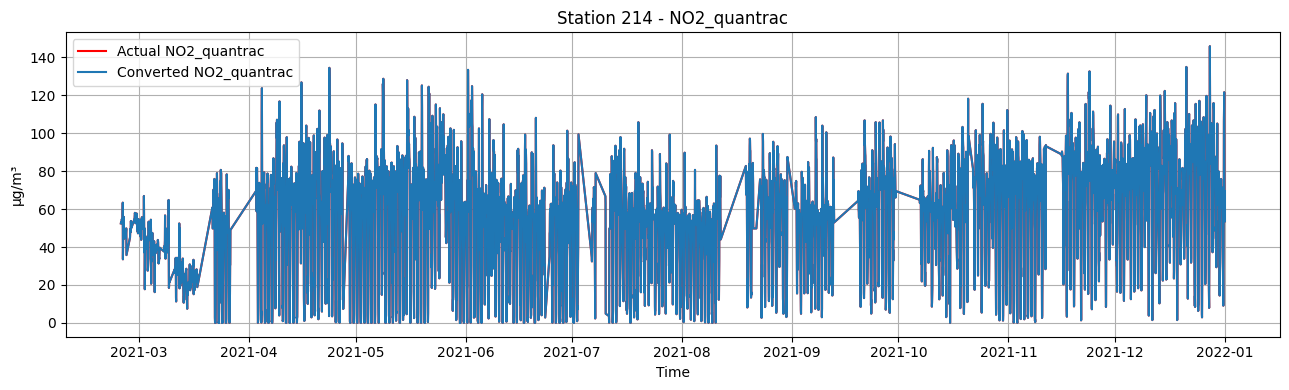

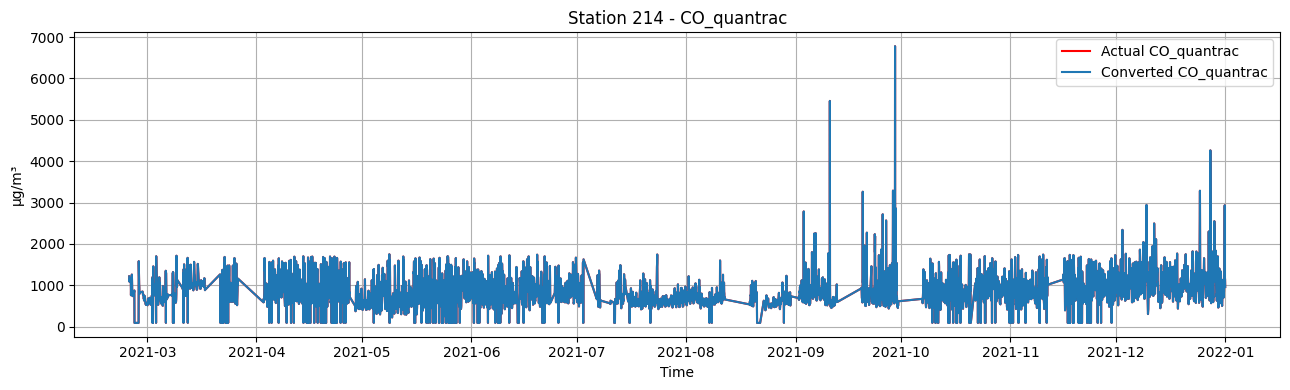

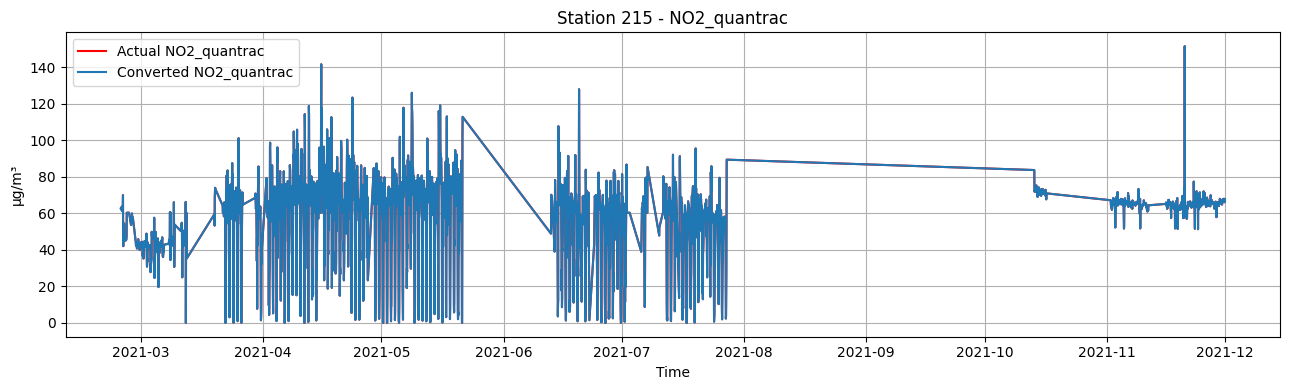

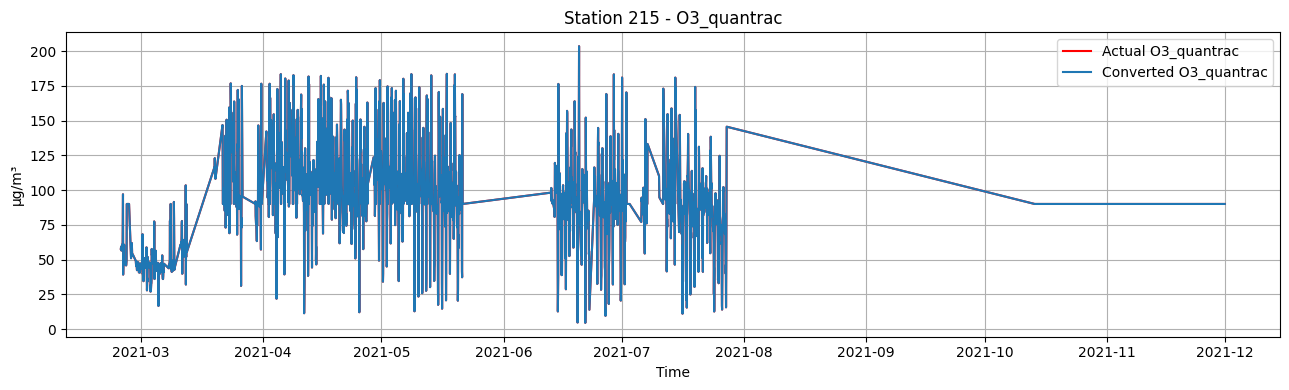

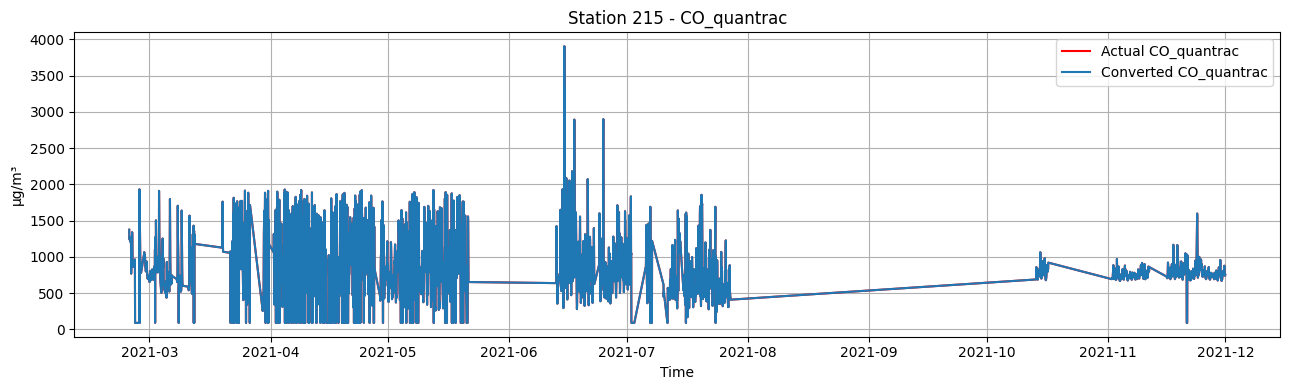

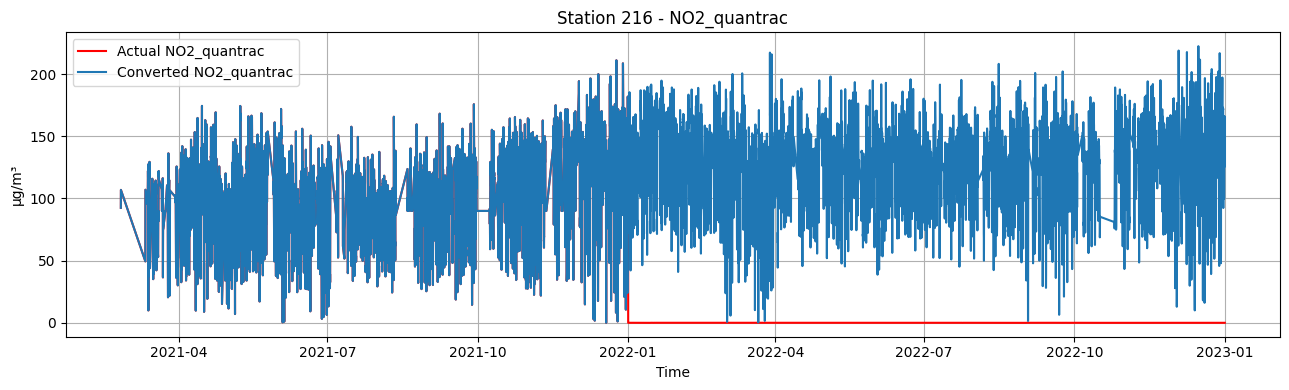

In [7]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [8]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 38709 records
After: 38692 records
Removed 17 records


## Visualization after removing outliers

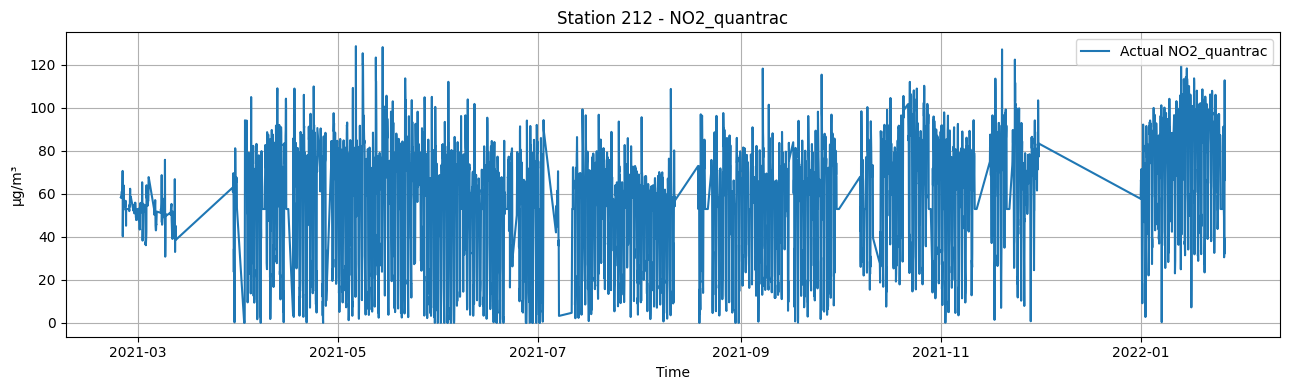

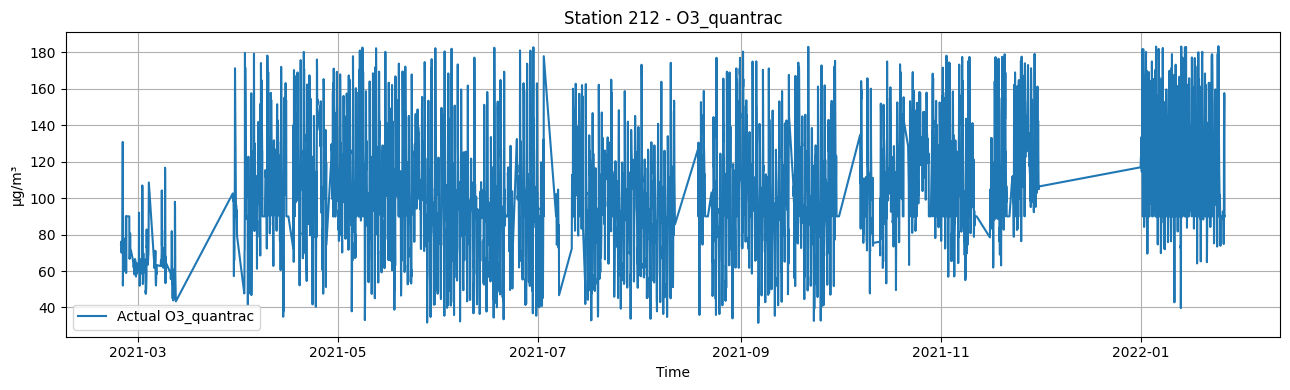

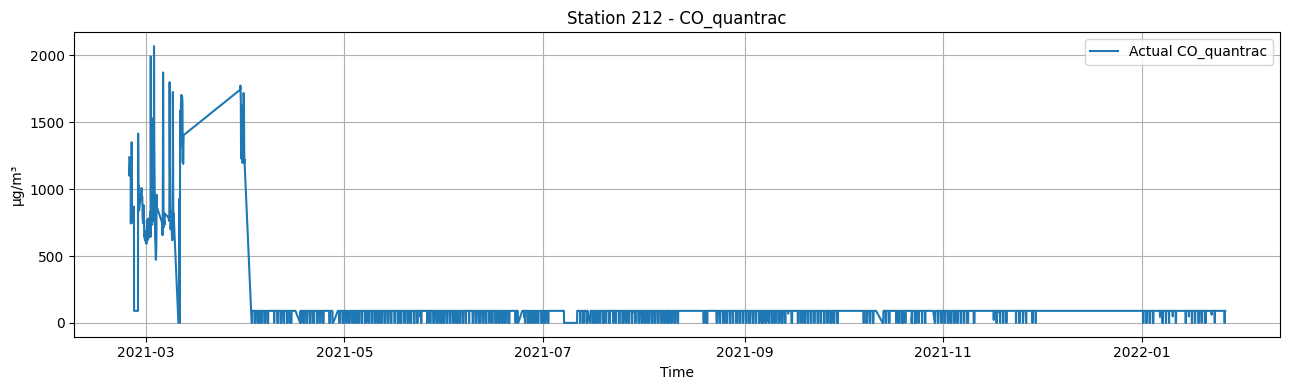

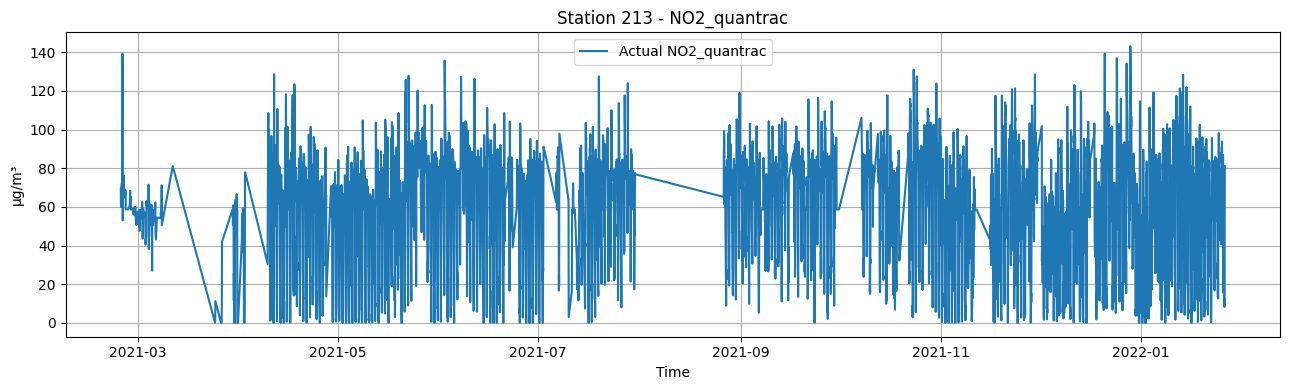

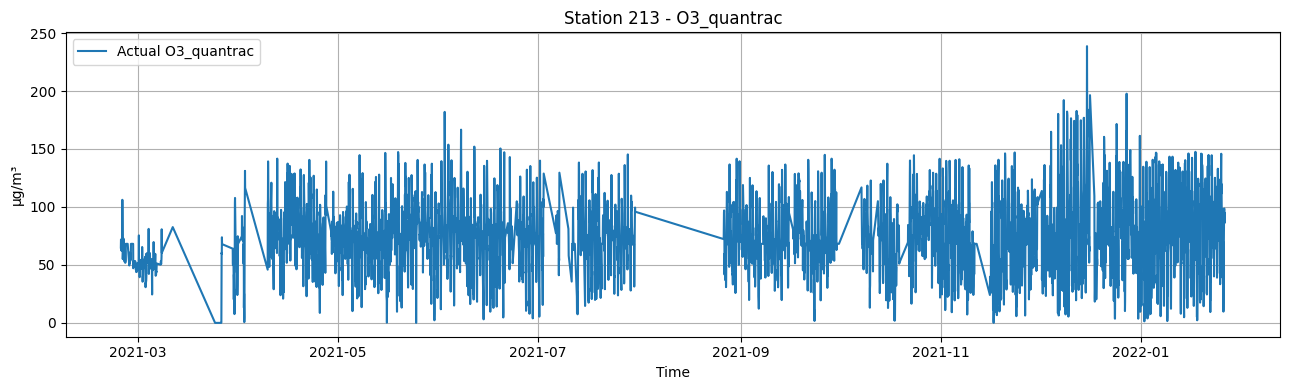

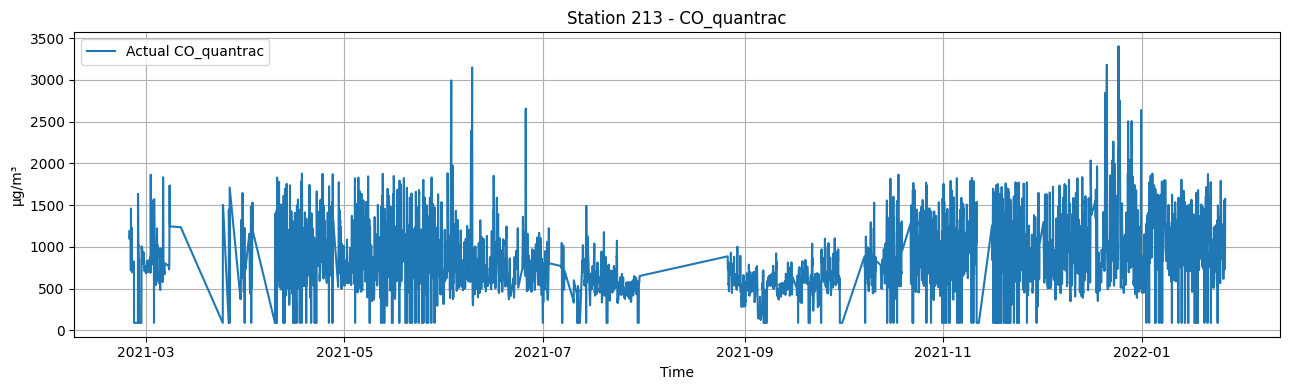

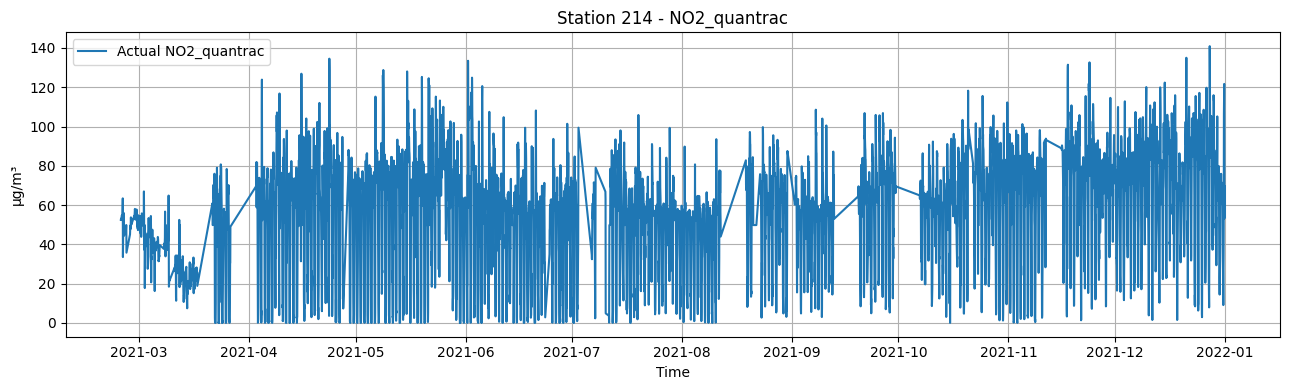

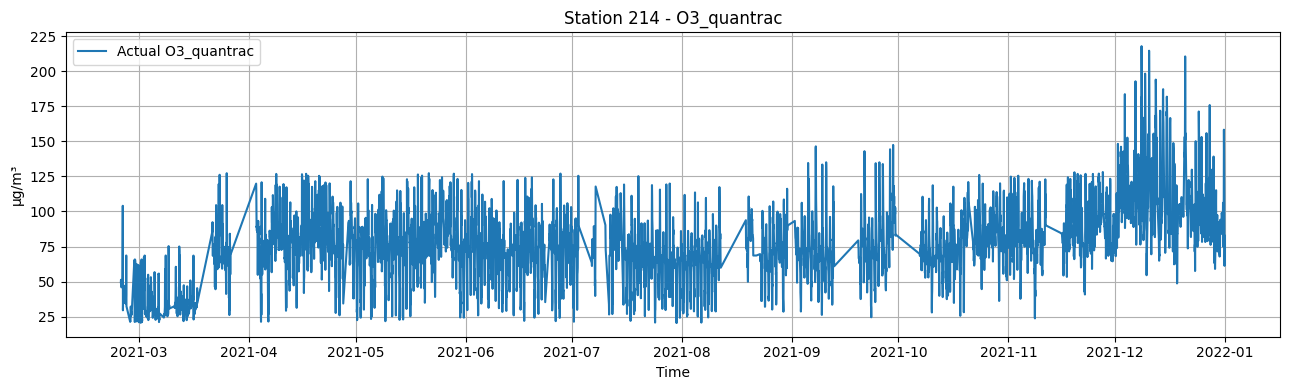

In [9]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

# Prepare test data with 72 records

In [10]:
df_test = df_converted.iloc[0:72]
df_test

date  NO2_quantrac  PM25_quantrac    O3_quantrac  \
0  2021-02-23 21:00:00   112.7407619  15.6047619000  55.4313809500   
1  2021-02-23 22:00:00   112.3664706  14.5941176500  58.1971764700   
2  2021-02-23 23:00:00   112.7004333  13.4366666700  55.0294333300   
3  2021-02-24 00:00:00   112.4808667  12.3650000000  54.7677000000   
4  2021-02-24 01:00:00   114.3315000  11.6366666700  53.7862000000   
..                 ...           ...            ...            ...   
67 2021-02-27 15:00:00    90.0000000  23.2058918881  69.1289407106   
68 2021-02-27 16:00:00    99.7460000  37.6000000000  62.8160000000   
69 2021-02-27 17:00:00   105.7213500  37.6600000000  69.4411250000   
70 2021-02-27 18:00:00   106.4271000  36.4800000000  63.7647833300   
71 2021-02-27 19:00:00   108.6855000  35.6633333300  68.0506666700   

    CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0     90.000000         28.3619047600   63.1880952400         211  
1   1200.603529         28.3205882400   63.7735294100         211  
2   1177.897000         28.3366666700   64.2050000000         211  
3     90.000000         28.3050000000   64.7350000000         211  
4     90.000000         28.3000000000   65.1883333300         211  
..          ...                   ...             ...         ...  
67    90.000000         28.9507149123   76.5272374968         211  
68    90.000000         29.1000000000   70.4000000000         211  
69  1186.110000         29.1100000000   70.2525000000         211  
70  1164.718000         29.0616666700   70.2366666700         211  
71  1110.092000         28.9750000000   70.1800000000         211  

[72 rows x 8 columns]

In [11]:
data = {}
for col in df_test.columns:
    new_col = col.lower().replace("_quantrac", "")
    data[new_col] = [str(item) for item in df_test[col].to_list()]

for k,v in data.items():
    print(f'"{k}": ', end='')
    if k == "date":
        formatted_items = [f'"{item}"' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    else:
        formatted_items = [f'{item}' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    print("\n")

"date": ["2021-02-23 21:00:00", "2021-02-23 22:00:00", "2021-02-23 23:00:00", "2021-02-24 00:00:00", "2021-02-24 01:00:00", "2021-02-24 02:00:00", "2021-02-24 03:00:00", "2021-02-24 04:00:00", "2021-02-24 05:00:00", "2021-02-24 06:00:00", "2021-02-24 07:00:00", "2021-02-24 08:00:00", "2021-02-24 09:00:00", "2021-02-24 10:00:00", "2021-02-24 11:00:00", "2021-02-24 12:00:00", "2021-02-24 13:00:00", "2021-02-24 14:00:00", "2021-02-24 15:00:00", "2021-02-24 16:00:00", "2021-02-24 17:00:00", "2021-02-24 18:00:00", "2021-02-24 19:00:00", "2021-02-24 20:00:00", "2021-02-24 21:00:00", "2021-02-24 22:00:00", "2021-02-24 23:00:00", "2021-02-25 00:00:00", "2021-02-25 01:00:00", "2021-02-25 02:00:00", "2021-02-25 03:00:00", "2021-02-25 04:00:00", "2021-02-25 05:00:00", "2021-02-25 06:00:00", "2021-02-25 07:00:00", "2021-02-25 08:00:00", "2021-02-25 09:00:00", "2021-02-25 10:00:00", "2021-02-25 11:00:00", "2021-02-26 11:00:00", "2021-02-26 12:00:00", "2021-02-26 13:00:00", "2021-02-26 14:00:00", "2

# Start calling API

### Adding time/lag features

In [12]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_test)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

print(df_lag_feats.columns)
display(df_lag_feats)

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id', 'hour',
       'dayofweek', 'month', 'NO2_quantrac_lag3', 'NO2_quantrac_lag6',
       'NO2_quantrac_lag12', 'NO2_quantrac_lag24', 'NO2_quantrac_lag48',
       'NO2_quantrac_lag71', 'PM25_quantrac_lag3', 'PM25_quantrac_lag6',
       'PM25_quantrac_lag12', 'PM25_quantrac_lag24', 'PM25_quantrac_lag48',
       'PM25_quantrac_lag71', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag71', 'CO_quantrac_lag3', 'CO_quantrac_lag6',
       'CO_quantrac_lag12', 'CO_quantrac_lag24', 'CO_quantrac_lag48',
       'CO_quantrac_lag71', 'Temperature_quantrac_lag3',
       'Temperature_quantrac_lag6', 'Temperature_quantrac_lag12',
       'Temperature_quantrac_lag24', 'Temperature_quantrac_lag48',
       'Temperature_quantrac_lag71', 'Humid_quantrac_lag3',
       'Humid_quantrac_lag6', 

date  NO2_quantrac  PM25_quantrac    O3_quantrac  \
0  2021-02-23 21:00:00   112.7407619  15.6047619000  55.4313809500   
1  2021-02-23 22:00:00   112.3664706  14.5941176500  58.1971764700   
2  2021-02-23 23:00:00   112.7004333  13.4366666700  55.0294333300   
3  2021-02-24 00:00:00   112.4808667  12.3650000000  54.7677000000   
4  2021-02-24 01:00:00   114.3315000  11.6366666700  53.7862000000   
..                 ...           ...            ...            ...   
67 2021-02-27 15:00:00    90.0000000  23.2058918881  69.1289407106   
68 2021-02-27 16:00:00    99.7460000  37.6000000000  62.8160000000   
69 2021-02-27 17:00:00   105.7213500  37.6600000000  69.4411250000   
70 2021-02-27 18:00:00   106.4271000  36.4800000000  63.7647833300   
71 2021-02-27 19:00:00   108.6855000  35.6633333300  68.0506666700   

    CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  hour  \
0     90.000000         28.3619047600   63.1880952400         211    21   
1   1200.603529         28.3205882400   63.7735294100         211    22   
2   1177.897000         28.3366666700   64.2050000000         211    23   
3     90.000000         28.3050000000   64.7350000000         211     0   
4     90.000000         28.3000000000   65.1883333300         211     1   
..          ...                   ...             ...         ...   ...   
67    90.000000         28.9507149123   76.5272374968         211    15   
68    90.000000         29.1000000000   70.4000000000         211    16   
69  1186.110000         29.1100000000   70.2525000000         211    17   
70  1164.718000         29.0616666700   70.2366666700         211    18   
71  1110.092000         28.9750000000   70.1800000000         211    19   

    dayofweek  ...  Temperature_quantrac_lag12  Temperature_quantrac_lag24  \
0           1  ...                         NaN                         NaN   
1           1  ...                         NaN                         NaN   
2           1  ...                         NaN                         NaN   
3           2  ...                         NaN                         NaN   
4           2  ...                         NaN                         NaN   
..        ...  ...                         ...                         ...   
67          5  ...               28.9507149123                 26.81500000   
68          5  ...               28.9507149123                 26.85666667   
69          5  ...               28.9507149123                 27.60666667   
70          5  ...               28.9507149123                 28.23000000   
71          5  ...               28.9507149123                 28.30000000   

    Temperature_quantrac_lag48  Temperature_quantrac_lag71  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         NaN   
3                          NaN                         NaN   
4                          NaN                         NaN   
..                         ...                         ...   
67                 25.78000000                         NaN   
68                 27.42166667                         NaN   
69                 27.72166667                         NaN   
70                 27.71833333                         NaN   
71                 27.77666667                 28.36190476   

    Humid_quantrac_lag3  Humid_quantrac_lag6  Humid_quantrac_lag12  \
0                   NaN                  NaN                   NaN   
1                   NaN                  NaN                   NaN   
2                   NaN                  NaN                   NaN   
3         63.1880952400                  NaN                   NaN   
4         63.7735294100                  NaN                   NaN   
..                  ...                  ...                   ...   
67        76.5272374968        76.5272374968         76.5272374968   
68        76.5272374968        76.

## NO2_quantrac

In [13]:
# Add rolling features for target_col
target_col = "NO2_quantrac"
df_no2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as no2_emb_file:
    no2_station_to_embedding = pickle.load(no2_emb_file)
print(no2_station_to_embedding)
df_no2, _ = attach_station_embedding(df_no2, no2_station_to_embedding, station_col="station_id")

# Dropna
df_no2 = df_no2.dropna()
display(df_no2)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_no2.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [7.782829, -4.09747, -4.5961213, 3.8078797], 212: [3.5855365, -3.9908829, -2.4162335, 1.0250082], 213: [2.9658248, -3.1664917, -2.539614, 2.5171337], 214: [1.5897979, -2.4742687, -4.4660373, 2.1730874], 215: [2.984351, -3.522223, -1.998513, 2.4715588], 216: [5.107183, -5.4918914, -6.1699085, 6.0908666]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac  \
71 2021-02-27 19:00:00      108.6855    35.66333333  68.05066667     1110.092   

    Temperature_quantrac  Humid_quantrac  station_id  hour  dayofweek  ...  \
71                28.975           70.18         211    19          5  ...   

    NO2_quantrac_roll24_mean  NO2_quantrac_roll24_std  \
71             95.6195432417             9.3655830399   

    NO2_quantrac_roll48_mean  NO2_quantrac_roll48_std  \
71             101.071788525             9.9801319504   

    NO2_quantrac_roll71_mean  NO2_quantrac_roll71_std  station_emb_0  \
71            104.3871829437            10.6787417331   7.7828288078   

    station_emb_1  station_emb_2  station_emb_3  
71  -4.0974698067  -4.5961213112   3.8078796864  

[1 rows x 63 columns]

Horizon: 1h - predicted: 107.03780449224159
Horizon: 24h - predicted: 107.48666751990098
Horizon: 48h - predicted: 107.31389872674681
Horizon: 72h - predicted: 107.81671223839999


## Training for O3

In [14]:
# Add rolling features for target_col
target_col = "O3_quantrac"
df_o3 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as o3_emb_file:
    o3_station_to_embedding = pickle.load(o3_emb_file)
print(o3_station_to_embedding)
df_o3, _ = attach_station_embedding(df_o3, o3_station_to_embedding, station_col="station_id")

# Dropna
df_o3 = df_o3.dropna()
display(df_o3)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_o3.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [6.3102427, -2.830071, -3.242811, -5.710138], 212: [5.6497054, -6.1378117, -4.827483, -6.0162816], 213: [4.3873553, -4.6534095, -4.2588835, -2.8678885], 214: [3.096077, -4.051208, -6.2767863, -3.596666], 215: [5.033126, -5.672511, -4.3594937, -5.4653296], 216: [3.4363449, -4.0281177, -4.587953, -2.7763786]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac  \
71 2021-02-27 19:00:00      108.6855    35.66333333  68.05066667     1110.092   

    Temperature_quantrac  Humid_quantrac  station_id  hour  dayofweek  ...  \
71                28.975           70.18         211    19          5  ...   

    O3_quantrac_roll24_mean  O3_quantrac_roll24_std  O3_quantrac_roll48_mean  \
71            69.1098235654            2.8753242889            64.3955707196   

    O3_quantrac_roll48_std  O3_quantrac_roll71_mean  O3_quantrac_roll71_std  \
71            9.9472289883             64.342598809           14.4312035596   

    station_emb_0  station_emb_1  station_emb_2  station_emb_3  
71   6.3102426529  -2.8300709724  -3.2428109646  -5.7101378441  

[1 rows x 63 columns]

Horizon: 1h - predicted: 65.01816403808824
Horizon: 24h - predicted: 66.33496920867843
Horizon: 48h - predicted: 68.69353359769734
Horizon: 72h - predicted: 69.89042502159886


## Training for CO

In [15]:
# Add rolling features for target_col
target_col = "CO_quantrac"
df_co = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_station_embedding.pkl"), "rb") as co_emb_file:
    co_station_to_embedding = pickle.load(co_emb_file)
print(co_station_to_embedding)
df_co, _ = attach_station_embedding(df_co, co_station_to_embedding, station_col="station_id")

# Dropna
df_co = df_co.dropna()
display(df_co)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_co.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [-9.1424675, -9.570723, -10.159096, 8.830111], 212: [-1.9979348, -4.0776124, -2.5172603, 1.1684203], 213: [-10.647095, -11.673682, -11.487389, 11.10486], 214: [-12.096144, -10.875263, -13.295887, 10.625471], 215: [-11.388142, -11.457361, -10.267969, 10.315793], 216: [-12.22883, -11.686434, -12.453338, 11.830644]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac  \
71 2021-02-27 19:00:00      108.6855    35.66333333  68.05066667     1110.092   

    Temperature_quantrac  Humid_quantrac  station_id  hour  dayofweek  ...  \
71                28.975           70.18         211    19          5  ...   

    CO_quantrac_roll24_mean  CO_quantrac_roll24_std  CO_quantrac_roll48_mean  \
71           318.1804431667          454.4809737742           438.3643480208   

    CO_quantrac_roll48_std  CO_quantrac_roll71_mean  CO_quantrac_roll71_std  \
71          459.7622540121           428.0972873338          454.0843130014   

    station_emb_0  station_emb_1  station_emb_2  station_emb_3  
71  -9.1424674988    -9.57072258 -10.1590957642   8.8301105499  

[1 rows x 63 columns]

Horizon: 1h - predicted: 846.3696267097802
Horizon: 24h - predicted: 744.9314941245956
Horizon: 48h - predicted: 725.895601930236
Horizon: 72h - predicted: 767.9131211373776
